<a href="https://colab.research.google.com/github/sushmit86/Statiistical_rethinking_jax/blob/main/sushmit_06__Haunted_DAG__and_The_Causal_Terror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
  !pip install jaxopt
  !pip install networkx
  !pip install arviz
  !pip install CausalGraphicalModel
except:
  pass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.0 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement CausalGraphicalModel (from versions: none)
ERROR: No matching distribution found for CausalGraphicalModel


In [ ]:
#@title import library
import numpy as np
import scipy.stats as stats
import pandas as pd
# import daft
import networkx as nx
import statsmodels.formula.api as smf
import jax
import io
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp_jax
from collections import OrderedDict
tfd = tfp_jax.distributions
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import jaxopt
from jaxopt import ScipyMinimize
import arviz
import itertools
import collections
import arviz as az
key = jax.random.PRNGKey(42)

def marginal_test_results(model, results, nll,credib_interval = 0.89, num_of_samples = 10000):
  '''
  model: tfp model like
  results: results from optimizing
  nll: negative log likelihood function
  credib_interval: the interval we are interested in
  num_of_samples: number of samples we want to get from the posterior distribution
  '''
  key = jax.random.PRNGKey(42)
  inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
  mean_list = results.params
  sd_list = jnp.diagonal(inv_hessian_matrix)**(1/2)
  low_credib_interval = (1 - credib_interval)/2
  high_credib_interval = 1 - low_credib_interval
  parameter_list = []
  normal_dist = tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list)
  for _parameter in model.parameters['model']:
    if isinstance(model.parameters['model'][_parameter],tfp_jax.distributions.Distribution):
      try:
        _shape = model.parameters['model'][_parameter].event_shape[0]
        parameter_list.extend([_parameter + '_' +str(i) for i in range(0, _shape)])
      except:
        parameter_list.append(_parameter)

  df_result = pd.DataFrame({'mean': mean_list,
                           'sd':sd_list,
                            'low': normal_dist.quantile(low_credib_interval),
                            'high':tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list).quantile(high_credib_interval) },
                           index = parameter_list)
  post_dist = tfp_jax.distributions.MultivariateNormalFullCovariance(
    loc=results.params,covariance_matrix=inv_hessian_matrix )
  post_samples = post_dist.sample( sample_shape=num_of_samples,seed=key)
  df_post_samples = pd.DataFrame(post_samples,columns = parameter_list)
  return df_result,inv_hessian_matrix,df_post_samples
credib_interval = 0.89

In [ ]:
#@title 6.1
np.random.seed(1914)  # Set seed for reproducibility
N = 200             # Number of grant proposals
p = 0.1              # Proportion to select

# Generate uncorrelated newsworthiness and trustworthiness scores
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)

# Calculate total score
s = nw + tw

# Determine the threshold for the top 10%
q = np.quantile(s, 1 - p)

# Select proposals above the threshold
selected = s >= q

# Calculate the correlation between trustworthiness and newsworthiness for selected proposals
correlation = np.corrcoef(tw[selected], nw[selected])[0,1]

print(correlation)


-0.6483929491294511


In [ ]:
#@title 6.2
N = 100
height = np.random.normal(10,2,N)
leg_prop = np.random.uniform(0.4,0.5,N)
leg_left = leg_prop*height + np.random.normal(0,0.02,N)
leg_right = leg_prop*height + np.random.normal(0,0.02,N)
d = pd.DataFrame({'height':height,'leg_left':leg_left,'leg_right':leg_right})

In [ ]:
#@title reading the data from book to simulate same results
d = pd.read_csv(io.StringIO('''
height,leg_left,leg_right
5.931416955,2.679411473,2.70928614
6.51298334,2.676427688,2.680006751
9.346627917,3.927154928,3.984946748
9.233033497,3.964191068,3.993388926
10.35712817,4.427593165,4.418765765
10.0889226,4.95664064,4.971877867
13.05303445,5.404191204,5.399219538
7.498360791,3.539438477,3.579225558
13.81087151,6.300341319,6.29822427
7.329084991,3.230945506,3.274145028
12.61932224,5.127566756,5.132084685
12.68391751,5.359608747,5.366324791
12.06613652,5.741060474,5.748175022
10.05801071,4.329188499,4.323138132
12.42722547,5.911001365,5.921830976
16.44880782,7.153321385,7.14551902
9.937349262,4.681807289,4.698755785
10.57496264,4.233973369,4.263162337
12.32543692,5.56312629,5.530779548
9.555444182,4.407019201,4.387076685
11.33216842,4.61139999,4.638060772
10.61995019,4.462987178,4.458933212
12.01106303,5.784778123,5.797436884
14.90090496,6.79271827,6.769172138
11.42808673,5.499870386,5.509709203
7.031058933,3.351868887,3.298516253
6.671679811,2.726206139,2.730960637
9.628514693,4.613382762,4.612500945
9.265901788,4.238859594,4.255222597
12.39715654,6.055246736,6.029016983
12.32260175,6.123998655,6.164206071
11.87632601,4.738791198,4.71019902
11.04261338,5.20969175,5.152977327
9.210152738,3.779994948,3.744403974
9.762566258,4.509882077,4.50721495
9.696829468,4.770419952,4.754229411
9.587857216,4.398377382,4.38829894
8.571497774,3.473194728,3.461114377
7.649834704,3.405669662,3.383477736
7.98868596,3.471506612,3.476156583
8.86399818,4.328689813,4.33207554
9.113498171,4.170678665,4.195822472
10.35862915,4.568490271,4.534296431
9.679261033,4.687564236,4.687122834
11.25014263,5.429219947,5.423695895
8.359474024,3.890150025,3.89460142
5.262048509,2.386818473,2.388972492
12.26802891,5.893525686,5.881967737
11.00900513,4.74893325,4.763609624
10.8072811,5.257132808,5.253323382
8.696513786,3.650035934,3.653937434
9.761014923,3.902102397,3.907399086
11.81638279,5.645260549,5.654353229
9.301588895,4.029298823,4.011371305
11.44441623,4.812517398,4.817390133
10.22876589,5.058965057,5.058070752
8.272049951,3.331294988,3.368051306
6.97898325,3.370056035,3.403965789
9.621701044,4.507635153,4.496517462
9.330807696,3.756904617,3.760564272
8.218764444,3.676938823,3.679898217
10.25447353,4.232952887,4.218270793
9.038639768,4.021331676,4.019803357
9.709572302,4.566335292,4.541757045
9.294864971,4.364862232,4.406905974
15.9633626,7.614862567,7.635012419
11.35074107,5.11651666,5.146136035
4.57493818,2.138929581,2.111308965
10.86622271,4.715935185,4.716034739
12.91511429,5.5384129,5.53313914
11.79853891,5.744965458,5.73853486
11.43930487,5.542637714,5.552836432
7.163051639,3.286217178,3.281855638
7.834305792,3.368747225,3.435448551
9.899587707,4.854784063,4.841924422
8.593783276,4.092027513,4.050168775
11.47050283,5.007675684,4.973286775
7.928694369,3.653731252,3.64113848
8.861765102,4.331312896,4.328131016
13.06150026,6.178552019,6.185445128
10.10898232,4.399288277,4.396729193
8.875610083,4.136185948,4.1436414
9.126544644,3.711032914,3.681410829
8.947473007,4.013302506,4.016245634
8.940897114,4.003867648,4.008472835
9.40444061,4.59669973,4.578378832
11.13370494,5.450681256,5.440490509
8.907264204,4.379276919,4.340107293
9.354004083,4.682148223,4.664959867
12.30994415,5.05015261,5.063904296
8.865257263,4.281116332,4.294385232
12.12543816,5.154836901,5.170920697
7.934998285,3.549989679,3.567998679
12.22482668,5.240380141,5.262400719
8.649402665,3.730091655,3.767939396
8.404878832,3.768040132,3.792619036
11.65886607,5.439036239,5.400221176
11.86387841,5.635256869,5.641282298
7.504671204,3.036804466,3.019554916
7.617914862,3.271645414,3.246423266
'''), header=0)
display(d.head())

,height,leg_left,leg_right
0,5.931417,2.679411,2.709286
1,6.512983,2.676428,2.680007
2,9.346628,3.927155,3.984947
3,9.233033,3.964191,3.993389
4,10.357128,4.427593,4.418766


In [ ]:
#@title 6.3
leg_left_arr = jnp.array(d['leg_left'])
leg_right_arr = jnp.array(d['leg_right'])
height_arr = jnp.array(d['height'])
model6_1 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=10.0,scale=100),
    bl = tfd.Normal(loc=2,scale=10),
    br = tfd.Normal(loc=2,scale=10),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda alpha,bl,br: tfd.Deterministic(alpha + bl * leg_left_arr + br * leg_right_arr),
    h = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
))
def nll6_1(parameters):
  samples = model6_1.sample(
      h = height_arr,
      alpha = parameters[0],
      bl = parameters[1],
      br = parameters[2],
      sigma = parameters[3],
      seed = jax.random.PRNGKey(42))
  return -1* model6_1.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll6_1,method='L-BFGS-B')
alpha_start = model6_1.parameters['model']['alpha'].mean()
bl_start = model6_1.parameters['model']['bl'].mean()
br_start = model6_1.parameters['model']['br'].mean()
sigma_start = model6_1.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,bl_start,br_start,sigma_start]))
df_result,cov_matrix,df_post_samples_m_6_1 = marginal_test_results(model6_1,results,nll6_1)
df_result.round(2)

,mean,sd,low,high
alpha,0.98,0.28,0.53,1.44
bl,0.21,2.53,-3.83,4.26
br,1.78,2.54,-2.27,5.84
sigma,0.62,0.04,0.55,0.69


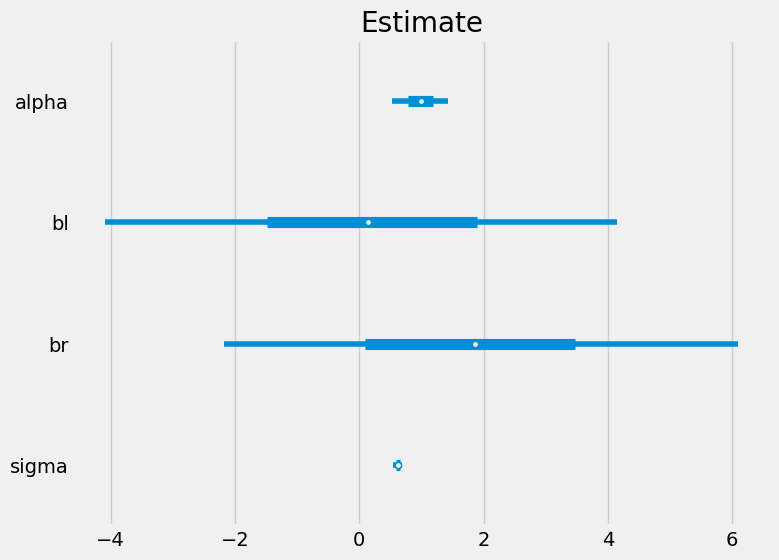

In [ ]:
#@title 6.4
fig,ax = plt.subplots(1,1,figsize=(8,6))
az.plot_forest(
data = {"alpha":df_post_samples_m_6_1['alpha'].values,"bl":df_post_samples_m_6_1['bl'].values,
        "br": df_post_samples_m_6_1['br'].values,
           "sigma":df_post_samples_m_6_1['sigma'].values },
hdi_prob=0.89,
ax=ax,
var_names=["alpha","bl","br","sigma"],

)
ax.set_title('Estimate')
plt.show()

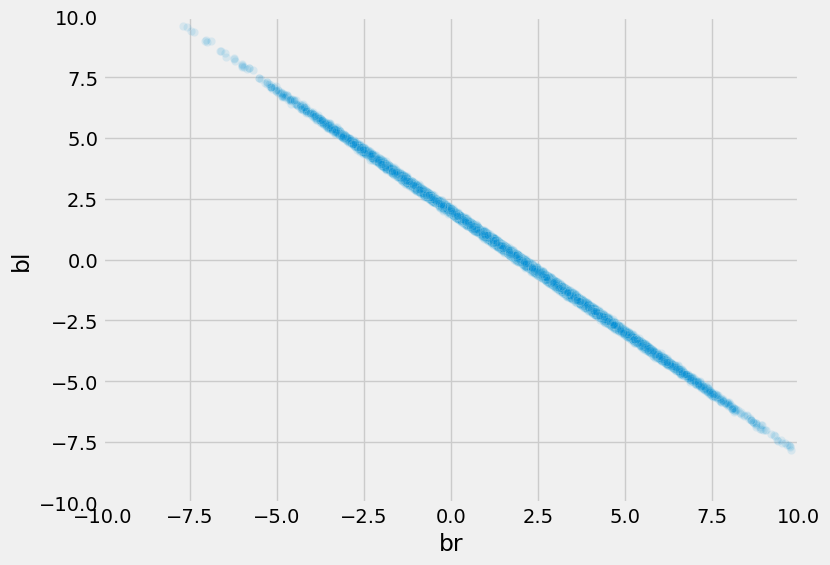

In [ ]:
#@title 6.5
fig,axs = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x='br', y='bl',  data=df_post_samples_m_6_1, alpha=0.1,
                legend=False, ax=axs)
axs.set_xlim(-10,10)
axs.set_ylim(-10,10)
axs.set_xlabel('br')
axs.set_ylabel('bl')
plt.show()

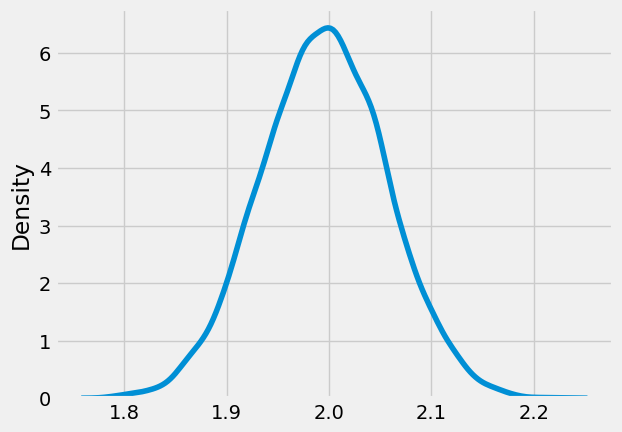

In [ ]:
#@title 6.6
sum_blbr = df_post_samples_m_6_1['bl'] + df_post_samples_m_6_1['br']
sns.kdeplot(sum_blbr)
plt.show()

In [ ]:
#@title 6.7
leg_left_arr = jnp.array(d['leg_left'])
leg_right_arr = jnp.array(d['leg_right'])
height_arr = jnp.array(d['height'])

model6_2 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=1.0,scale=0.5),
    bl = tfd.Normal(loc=2,scale=0.1),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda alpha,bl: tfd.Deterministic(alpha + bl * leg_left_arr),
    h = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
))
def nll6_2(parameters):
  samples = model6_2.sample(
      h = height_arr,
      alpha = parameters[0],
      bl = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model6_2.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_2,method='L-BFGS-B')
alpha_start = model6_2.parameters['model']['alpha'].mean()
bl_start = model6_2.parameters['model']['bl'].mean()
sigma_start = model6_2.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,bl_start,sigma_start]))
df_result,cov_matrix,df_post_samples_m_6_2 = marginal_test_results(model6_2,results,nll6_2)
df_result.round(2)

,mean,sd,low,high
alpha,0.99,0.22,0.64,1.34
bl,1.99,0.05,1.92,2.07
sigma,0.62,0.04,0.55,0.69


In [ ]:
#@title 6.8
milk = pd.read_csv('https://raw.githubusercontent.com/sushmit86/Statiistical_rethinking_jax/main/milk.csv',sep= ';')
d = milk.copy()
display(d.info())
d.head()
d["K"] = d['kcal.per.g'].pipe(lambda x: (x - x.mean())/x.std())
d["F"] = d['perc.fat'].pipe(lambda x: (x - x.mean())/x.std())
d["L"] = d['perc.lactose'].pipe(lambda x: (x - x.mean())/x.std())

K_arr = jnp.array(d.K)
F_arr = jnp.array(d.F)
L_arr = jnp.array(d.L)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


None

In [ ]:
#@title 6.9
model6_3 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    a = tfd.Normal(loc=0.0,scale=0.2),
    bF = tfd.Normal(loc=0.0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda a,bF: tfd.Deterministic(a + bF * F_arr),
    K = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
))
def nll6_3(parameters):
  samples = model6_3.sample(
      K = K_arr,
      a = parameters[0],
      bF = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model6_3.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll6_3,method='L-BFGS-B')
a_start = model6_3.parameters['model']['a'].mean()
bF_start = model6_3.parameters['model']['bF'].mean()
sigma_start = 2.0

results = optimize_fn.run(init_params=jnp.array([a_start,bF_start,sigma_start]))
df_result_m_6_3,cov_matrix,df_post_samples_m_6_3 = marginal_test_results(model6_3,results,nll6_3)
df_result_m_6_3.round(2)


,mean,sd,low,high
a,0.00,0.08,-0.12,0.12
bF,0.86,0.08,0.73,1.00
sigma,0.45,0.06,0.36,0.54


In [ ]:
#@title 6.9
model6_4 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    a = tfd.Normal(loc=0.0,scale=0.2),
    bL = tfd.Normal(loc=0.0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda a,bL: tfd.Deterministic(a + bL * L_arr),
    K = lambda mu,sigma: tfd.Normal(loc=mu,scale=sigma)
))
def nll6_4(parameters):
  samples = model6_4.sample(
      K = K_arr,
      a = parameters[0],
      bL = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model6_4.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll6_4,method='L-BFGS-B')
a_start = model6_4.parameters['model']['a'].mean()
bL_start = model6_4.parameters['model']['bL'].mean()
sigma_start = 2.0

results = optimize_fn.run(init_params=jnp.array([a_start,bL_start,sigma_start]))
df_result_m_6_4,cov_matrix,df_post_samples_m_6_4 = marginal_test_results(model6_4,results,nll6_4)
df_result_m_6_4.round(2)

,mean,sd,low,high
a,-0.00,0.07,-0.11,0.11
bL,-0.90,0.07,-1.02,-0.79
sigma,0.38,0.05,0.30,0.46


In [ ]:
#@title 6.10
model6_5 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    a = tfd.Normal(loc=0.0,scale=0.2),
    bL = tfd.Normal(loc=0.0,scale=0.5),
    bF = tfd.Normal(loc=0.0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda a,bL,bF: tfd.Deterministic(a + bL * L_arr + bF * F_arr),
    K = lambda mu,sigma: tfd.Normal(mu,sigma)
)
)
def nll6_5(parameters):
  samples = model6_5.sample(
      K = K_arr,
      a = parameters[0],
      bL = parameters[1],
      bF = parameters[2],
      sigma = parameters[3],
      seed = jax.random.PRNGKey(42))
  return -1* model6_5.log_prob(samples)
optimize_fn = ScipyMinimize(fun= nll6_5,method='L-BFGS-B')
a_start = model6_5.parameters['model']['a'].mean()
bL_start = model6_5.parameters['model']['bL'].mean()
bF_start = model6_5.parameters['model']['bF'].mean()
sigma_start = model6_5.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([a_start,bL_start,bF_start,sigma_start]))
df_result_m_6_5,cov_matrix,df_post_samples_m_6_5 = marginal_test_results(model6_5,results,nll6_5)
df_result_m_6_5.round(2)

,mean,sd,low,high
a,-0.00,0.07,-0.11,0.11
bL,-0.68,0.18,-0.97,-0.38
bF,0.24,0.18,-0.05,0.54
sigma,0.38,0.05,0.30,0.46


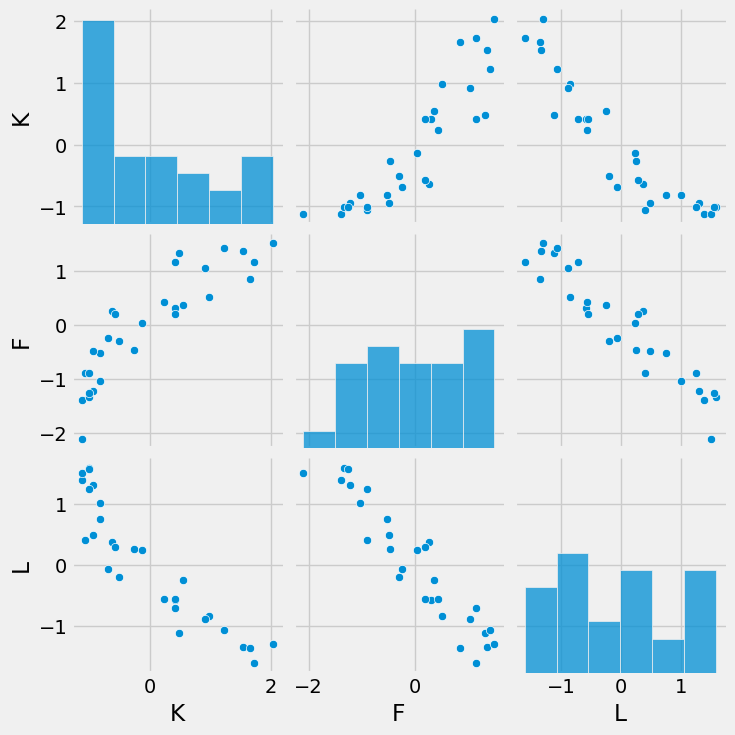

In [ ]:
#@title 6.11
sns.pairplot(d[['K','F','L']])
fig.show()

In [ ]:
d1 = d.copy()
d1.rename(columns= {"kcal.per.g":"kcal_per_g","perc.fat":"perc_fat"},inplace=True)
d1.head()

,clade,species,kcal_per_g,perc_fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


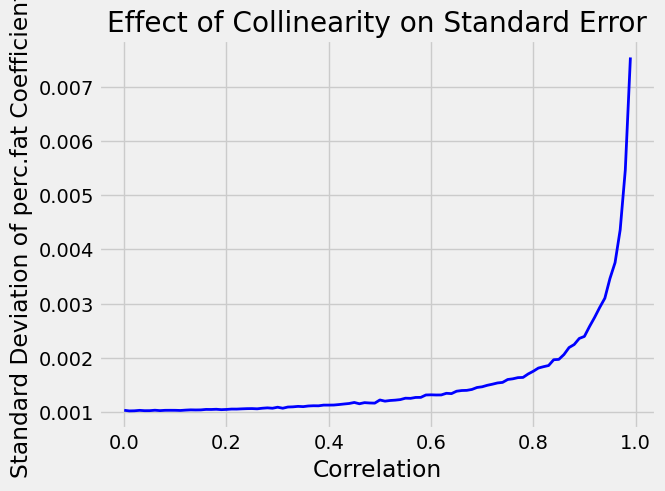

In [24]:
#@title 6.12 [consider changing the code. Extremly slow as of now]
def sim_coll(r=0.9):
  """Simulates correlated variable and fits a linear model."""
  d1['x'] = np.random.normal(loc=r * d1['perc_fat'],
                            scale=np.sqrt((1 - r**2) * np.var(d1['perc_fat'])),
                            size=len(d1))
  model = smf.ols('kcal_per_g ~ perc_fat + x', data=d1).fit()
  return np.sqrt(np.diag(model.cov_params()))[1]  # Stddev of perc.fat coeff

def rep_sim_coll(r=0.9, n=100):
  """Repeats the simulation and calculates the mean standard deviation."""
  stddevs = [sim_coll(r) for _ in range(n)]
  return np.mean(stddevs)

r_seq = np.arange(0, 1, 0.01)
stddevs = [rep_sim_coll(r=z, n=100) for z in r_seq]

plt.plot(r_seq, stddevs, linestyle='-', color='blue', linewidth=2)
plt.xlabel('Correlation')
plt.ylabel('Standard Deviation of perc.fat Coefficient')
plt.title('Effect of Collinearity on Standard Error')
plt.show()1

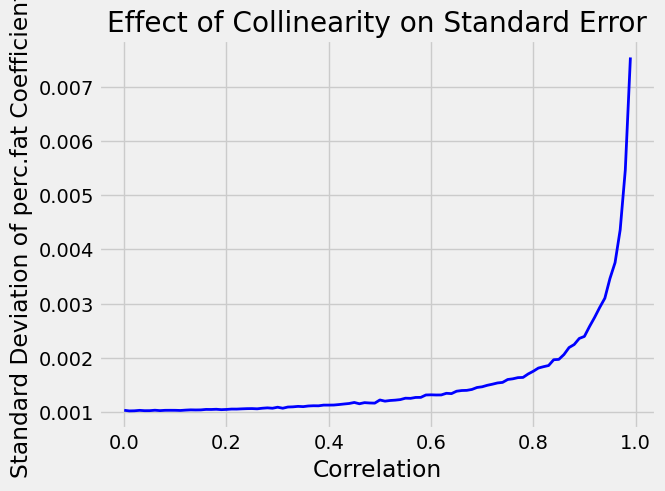

In [52]:
#@title 6.12 [This is much faster]
from scipy.optimize import curve_fit
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r**2) * np.var(d["perc.fat"])))
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.plot(r_seq, stddevs, linestyle='-', color='blue', linewidth=2)
plt.xlabel('Correlation')
plt.ylabel('Standard Deviation of perc.fat Coefficient')
plt.title('Effect of Collinearity on Standard Error')
plt.show()

In [23]:
# This is using np.vectorize but that is slow as well
# def sim_coll(r=0.9):
#   """Simulates correlated variable and fits a linear model."""
#   d1['x'] = np.random.normal(loc=r * d1['perc_fat'],
#                             scale=np.sqrt((1 - r**2) * np.var(d1['perc_fat'])),
#                             size=len(d1))
#   model = smf.ols('kcal_per_g ~ perc_fat + x', data=d1).fit()
#   return np.sqrt(np.diag(model.cov_params()))[1]  # Stddev of perc.fat coeff

# def rep_sim_coll(r=0.9, n=100):
#   """Repeats the simulation and calculates the mean standard deviation."""
#   v_sim_roll = np.vectorize(sim_coll)
#   array_n = np.repeat(r, n)
#   stddevs = v_sim_roll(array_n)
#   return np.mean(stddevs)

# v_rep_sim = np.vectorize(rep_sim_coll)
# r_seq = np.arange(0, 1, 0.01)
# stddevs = v_rep_sim(r=r_seq, n=100)


# plt.plot(r_seq, stddevs, linestyle='-', color='blue', linewidth=2)  # 'rangi2' replaced with blue
# plt.xlabel('Correlation')
# plt.ylabel('Standard Deviation of perc.fat Coefficient')
# plt.title('Effect of Collinearity on Standard Error')
# plt.show()



In [49]:

import jax.numpy as jnp
def custom_dot(x, y):
    return jnp.dot(x, y) ** 2

x = jnp.asarray([
    [2, 2, 2],
    [3, 3, 3]
])

y = jnp.asarray([
    [4, 4, 4],
    [5, 5, 5]
])
batched_custom_dot = jax.vmap(custom_dot, in_axes=[0, 0])
batched_custom_dot(x, y)

Array([ 576, 2025], dtype=int32)